# Creating a System

## Conventional methods

Systems are defined by a recycle stream (i.e. a tear stream; if any), and a path of unit operations and nested systems. A System object takes care of solving recycle streams by iteratively running its path of units and subsystems until the recycle converges to steady state. Systems can be manually created or automatically generated via the flowsheet or by context management.

### Manually generated

Manually creating a system is **not recommended** as it requires an exponential amount of time and effort for an individual to layout an accurate path. Here we create a trivial system manually as a simple exercise:

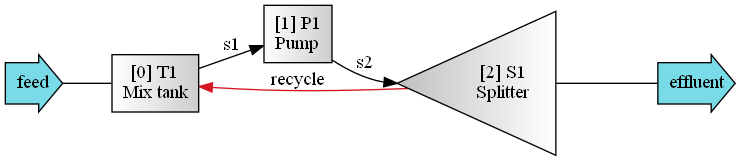

In [1]:
import biosteam as bst
bst.settings.set_thermo(['Water'])
feed = bst.Stream('feed', Water=100)
recycle = bst.Stream('recycle')
effluent = bst.Stream('effluent')
T1 = bst.MixTank('T1', ins=[feed, recycle])
P1 = bst.Pump('P1', T1-0)
S1 = bst.Splitter('S1', P1-0, [effluent, recycle], split=0.5)
manual_sys = bst.System('manual_sys', path=[T1, P1, S1], recycle=recycle)
manual_sys.simulate()
manual_sys.diagram(
    kind='cluster', # Cluster diagrams highlight recycle streams and nested systems.
    number=True, # This numbers each unit according to their path order
) 

In [2]:
manual_sys.show()

System: manual_sys
Highest convergence error among components in recycle
stream S1-1 after 3 loops:
- flow rate   0.00e+00 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100
outs...
[0] effluent
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100


Note that the inlets and outlets to a system are inherently connected to the unit operations within the system, but we can still connect systems just like unit operations, as depicted future examples.

### Autogenerated from the flowsheet

The **recommended** way of creating systems is to use the flowsheet. Here we expand on the existing process and create a new system using the flowsheet:

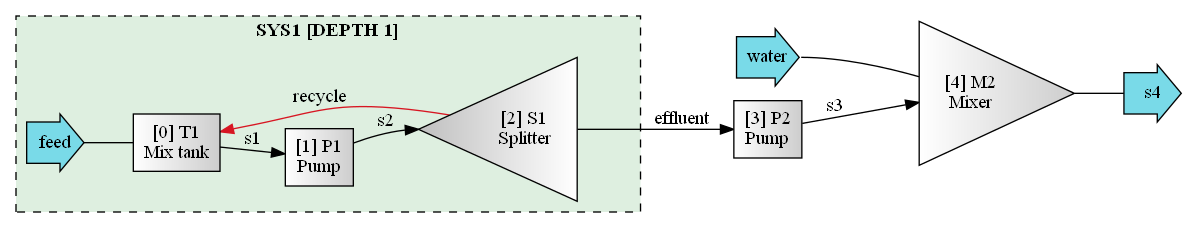

In [3]:
water = bst.Stream('water', Water=10)
P2 = bst.Pump('P2', manual_sys-0) # -pipe- notation equivalent to manual_sys.outs[0]
M2 = bst.Mixer('M2', [P2-0, water])
flowsheet_sys = bst.main_flowsheet.create_system('flowsheet_sys')
flowsheet_sys.simulate()
flowsheet_sys.diagram(kind='cluster', number=True)

In [4]:
flowsheet_sys.show()

System: flowsheet_sys
ins...
[0] feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100
[1] water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  10
outs...
[0] s4
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  110


### Autogenerated by context management

System objects' context management feature allows for creating systems of only the units created within the given context:

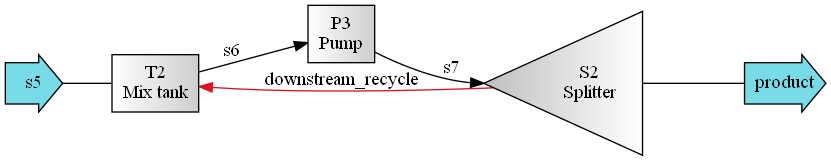

In [5]:
downstream_recycle = bst.Stream('downstream_recycle')
product = bst.Stream('product')
with bst.System('context_sys') as context_sys:
    T2 = bst.MixTank('T2', ins=['', downstream_recycle])
    P3 = bst.Pump('P3', T2-0)
    S2 = bst.Splitter('S2', P3-0, [product, downstream_recycle], split=0.5)
# The feed is empty, no need to run system (yet)
context_sys.diagram('cluster')

In [6]:
context_sys.show()

System: context_sys
Highest convergence error among components in recycle
stream S2-1 after 0 loops:
- flow rate   0.00e+00 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] s5
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
outs...
[0] product
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


Let's connect two systems together and create a new system from the flowsheet:

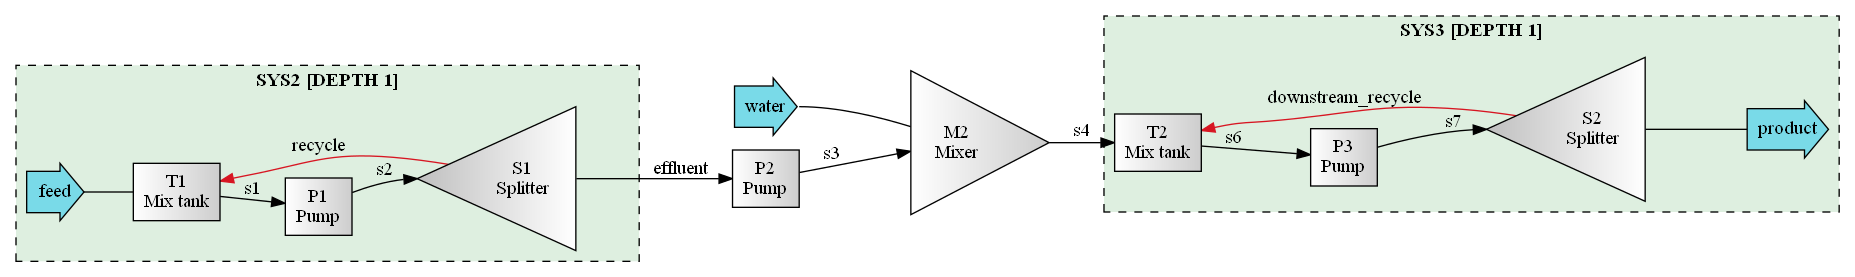

In [7]:
# -pipe- notation equivalent to context_sys.ins[:] = [flowsheet_sys.outs[0]]
flowsheet_sys-0-context_sys 
complete_sys = bst.main_flowsheet.create_system('complete_sys')
complete_sys.simulate()
complete_sys.diagram('cluster')

In [8]:
complete_sys.show()

System: complete_sys
ins...
[0] feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100
[1] water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  10
outs...
[0] product
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  110


## Drop-in systems

### A simple example

When a system is created by a function, it's called a drop-in system. Here, we create a sugarcane to ethanol production system without facilities (e.g., cooling tower, boiler) by using drop-in systems:

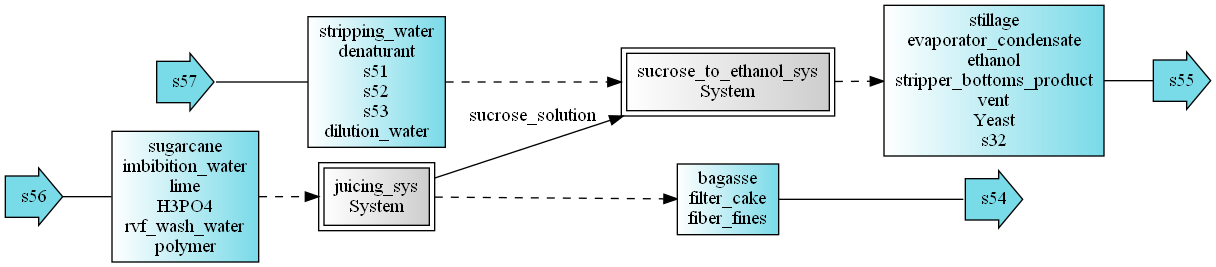

In [9]:
from biorefineries.sugarcane import chemicals
from biosteam import Stream, System, settings, main_flowsheet
from biorefineries.sugarcane import (
    create_juicing_system_with_fiber_screener as create_juicing_system,
    create_sucrose_to_ethanol_system 
)

main_flowsheet.clear() # Remove previous unit operations to prevent ID-conflict warnings
settings.set_thermo(chemicals)
denaturant = Stream('denaturant',
                    Octane=230.69,
                    units='kg/hr',
                    price=0.756)
sucrose_solution = Stream('sucrose_solution')

juicing_sys = create_juicing_system(
    ID='juicing_sys', # ID of system
    outs=[sucrose_solution], # Place sucrose_solution at the 0th outlet (all other streams are defaulted)
) 
sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(ins=[sucrose_solution, denaturant]) 

# Here are a couple of other ways to connect systems:
#   Manually:
#   >>> sucrose_to_ethanol_sys.ins[0] = juicing_sys.outs[0]
#   With -pipe- notation:
#   >>> juicing_sys-0-0-sucrose_to_ethanol_sys 

# Manually create a new system and simulate
sugarcane_to_ethanol_sys = System('sugarcane_to_ethanol_sys', 
                                  path=[juicing_sys, sucrose_to_ethanol_sys])
sugarcane_to_ethanol_sys.simulate()
sugarcane_to_ethanol_sys.diagram(kind='surface')

In [10]:
sugarcane_to_ethanol_sys.show(data=False)

System: sugarcane_to_ethanol_sys
ins...
[0] imbibition_water
[1] sugarcane
[2] rvf_wash_water
[3] H3PO4
[4] lime
[5] polymer
[6] s51
[7] stripping_water
[8] dilution_water
[9] denaturant
[10] s52
[11] s53
outs...
[0] filter_cake
[1] fiber_fines
[2] bagasse
[3] vent
[4] evaporator_condensate
[5] stillage
[6] Yeast
[7] stripper_bottoms_product
[8] ethanol
[9] s32


The number of inlets and outlets are rather large. It may be helpful to specify what inlets and outlets do we want to expose:

In [11]:
s = main_flowsheet.stream
sugarcane_to_ethanol_sys.load_inlet_ports([s.sugarcane])
sugarcane_to_ethanol_sys.load_outlet_ports([s.ethanol, s.bagasse])
sugarcane_to_ethanol_sys.show(data=False)

System: sugarcane_to_ethanol_sys
ins...
[0] sugarcane
outs...
[0] ethanol
[1] bagasse


The ethanol product is now the 0th stream

In [12]:
sucrose_to_ethanol_sys.outs[0].show()

Stream: ethanol from <StorageTank: T304>
 phase: 'l', T: 339.28 K, P: 101325 Pa
 flow (kmol/hr): Water    10.4
                 Ethanol  491
                 Octane   4.39


### System factories

Both `create_juicing_system` and `create_sucrose_to_ethanol_system` are [SystemFactory](../process_tools/SystemFactory.txt) objects, which accept the system `ID`, `ins`, and `outs` (similar to unit operations) and return a new system. Let's first have a look at some of the system factories in the [biorefineries.sugarcane](https://github.com/BioSTEAMDevelopmentGroup/Bioindustrial-Park/tree/master/BioSTEAM%202.x.x/biorefineries/sugarcane) library:  

In [13]:
create_juicing_system.show()
print()
create_sucrose_to_ethanol_system.show() 

SystemFactory(
    f=<create_juicing_system_with_fiber_screener(ins, outs, pellet_bagasse=None)>,
    ID='juicing_sys',
    ins=[dict(ID='sugarcane',
              Water=0.7,
              Glucose=0.01208,
              Sucrose=0.1369,
              Ash=0.006,
              Cellulose=0.06115,
              Hemicellulose=0.03608,
              Lignin=0.03276,
              Solids=0.015,
              total_flow=333334.2,
              units='kg/hr',
              price=0.03455),
         dict(ID='H3PO4',
              H3PO4=74.23,
              Water=13.1,
              units='kg/hr',
              price=0),
         dict(ID='lime',
              CaO=333.0,
              Water=2200.0,
              units='kg/hr',
              price=0.077),
         dict(ID='polymer',
              Flocculant=0.83,
              units='kg/hr',
              price=0)],
    outs=[dict(ID='screened_juice'),
          dict(ID='bagasse'),
          dict(ID='fiber_fines')]
)

SystemFactory(
    f=<create_sucr

[SystemFactory](../process_tools/SystemFactory.txt) objects are composed of a function `f` which creates the unit operations, a predefined system `ID`, and `ins` and `outs` dictionaries that serve as keyword arguments to initialize the system's default inlets and outlets. 

The signature of a SystemFactory is `f(ID=None, ins=None, outs=None, mockup=False, area=None, udct=None, ...)`. The additional parameters (i.e. mockup, area, and udct) will be discussed in the next section.

### Saving time with mock systems

When creating a biorefinery, we may not be interested in all the subsystems we created with SystemFactory objects. We can save a few milliseconds in computational time (per system) by using mock systems:

In [14]:
main_flowsheet.clear() # Remove previous unit operations to prevent ID-conflict warnings
juicing_sys = create_juicing_system(
    outs=[sucrose_solution],
    mockup=True
) 
sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(
    ins=[sucrose_solution, denaturant],
    mockup=True
) 
# Note that mock systems don't have anything other than `ins`, `outs`, and `units` 
juicing_sys.show()
sucrose_to_ethanol_sys.show()

MockSystem(
    ins=[0-U201, 1-T203, 0-T204, 1-T206],
    outs=[S202-0, U202-0, S202-1],
    units=[U201, U202, M201, S201, T202,
           H201, T203, P201, T204, T205,
           P202, M202, H202, T206, C201,
           C202, P203, S202]
)
MockSystem(
    ins=[0-S301, 0-T303],
    outs=[T304-0, H302-1, P303-0, F301-1],
    units=[S301, F301, M301, H301, R301,
           T301, D301, M302, C301, S302,
           T305, P306, P301, D302, P302,
           H302, M303, D303, P303, H303,
           U301, H304, T302, P304, T303,
           P305, M304, T304]
)


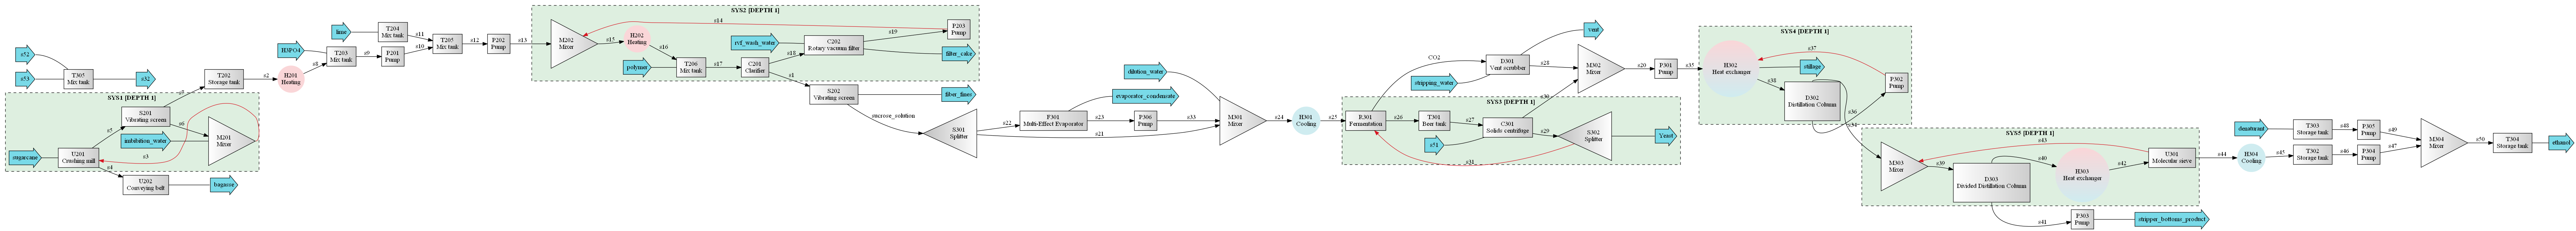

In [15]:
# We can create the system using the flowsheet
sugarcane_to_ethanol_sys = main_flowsheet.create_system('sugarcane_to_ethanol_sys')
sugarcane_to_ethanol_sys.simulate()
sugarcane_to_ethanol_sys.diagram()

In [16]:
sucrose_to_ethanol_sys.outs[0].show()

Stream: ethanol from <StorageTank: T304>
 phase: 'l', T: 339.28 K, P: 101325 Pa
 flow (kmol/hr): Water    10.4
                 Ethanol  491
                 Octane   4.39


### Using the area naming convention

The area naming convention follows {letter}{area + number} where the letter depends on
the unit operation as follows:

* C: Centrifuge
* D: Distillation column
* E: Evaporator
* F: Flash tank
* H: Heat exchange
* M: Mixer
* P: Pump (including conveying belt)
* R: Reactor
* S: Splitter (including solid/liquid separator)
* T: Tank or bin for storage
* U: Other units
* J: Junction, not a physical unit (serves to adjust streams)
* PS: Process specificiation, not a physical unit (serves to adjust streams)

For example, the first mixer in area 100 would be named M101. When calling a SystemFactory object, we can pass the `area` to name unit operations according to the area convention. In the following example, we name all unit operations in the juicing system under area 300:

In [17]:
main_flowsheet.clear() # Remove previous unit operations
juicing_sys = create_juicing_system(area=300, mockup=True) 
juicing_sys.show()

MockSystem(
    ins=[0-U301, 1-T302, 0-T303, 1-T305],
    outs=[U306-0, U302-0, U306-1],
    units=[U301, U302, M301, U303, T301,
           H301, T302, P301, T303, T304,
           P302, M302, H302, T305, U304,
           U305, P303, U306]
)


To access unit operations by their default ID (as originally defined in SystemFactory code), you can request a unit dictionary by passing `udct`=True:

In [18]:
main_flowsheet.clear() # Remove previous unit operations
# When udct is True, both the system and the unit dictionary are returned 
juicing_sys, udct = create_juicing_system(mockup=True, area=300, udct=True) 
unit = udct['U201']
print(repr(unit)) # Originally, this unit was named U201

<CrushingMill: U301>


### Creating system factories 

Create a SystemFactory object for creating sugarcane to ethanol systems: 

In [19]:
from biosteam import System, SystemFactory

@SystemFactory(
    ID='sugarcane_to_ethanol_sys',
    ins=[create_juicing_system.ins[0], # Reuse default from juicing system factory
         dict(ID='denaturant',
              price=0.756)],
    outs=[dict(ID='ethanol',
               price=0.789),
          dict(ID='bagasse')]
)
def create_sugarcane_to_ethanol_system(ins, outs):
    # ins and outs will be stream objects
    sugarcane, denaturant = ins
    ethanol, bagasse = outs
    juicing_sys = create_juicing_system(
        ins=sugarcane, 
        outs=[None, bagasse], # None will default to a stream
        mockup=True
    ) 
    sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(
        ins=(juicing_sys-0, denaturant),
        outs=ethanol,
        mockup=True,
    )
    # The system factory builds a system from units created by the function

create_sugarcane_to_ethanol_system.show()

SystemFactory(
    f=<create_sugarcane_to_ethanol_system(ins, outs)>,
    ID='sugarcane_to_ethanol_sys',
    ins=[dict(ID='sugarcane',
              Water=0.7,
              Glucose=0.01208,
              Sucrose=0.1369,
              Ash=0.006,
              Cellulose=0.06115,
              Hemicellulose=0.03608,
              Lignin=0.03276,
              Solids=0.015,
              total_flow=333334.2,
              units='kg/hr',
              price=0.03455),
         dict(ID='denaturant',
              price=0.756)],
    outs=[dict(ID='ethanol',
               price=0.789),
          dict(ID='bagasse')]
)


Create the sugarcane to ethanol system and simulate:

In [20]:
main_flowsheet.clear() # Remove previous unit operations
sugarcane_to_ethanol_sys = create_sugarcane_to_ethanol_system()
sugarcane_to_ethanol_sys.simulate()
sugarcane_to_ethanol_sys.show()

System: sugarcane_to_ethanol_sys
ins...
[0] sugarcane
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water          1.3e+04
                    Glucose        22.4
                    Sucrose        133
                    Ash            2e+03
                    Cellulose      126
                    Hemicellulose  91
                    Lignin         71.8
                    ...
[1] denaturant
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Octane  4.39
outs...
[0] ethanol
    phase: 'l', T: 339.28 K, P: 101325 Pa
    flow (kmol/hr): Water    10.4
                    Ethanol  491
                    Octane   4.39
[1] bagasse
    phase: 'l', T: 310.52 K, P: 101325 Pa
    flow (kmol/hr): Water          2.84e+03
                    Glucose        1.01
                    Sucrose        6.03
                    Ash            1.94e+03
                    Cellulose      122
                    Hemicellulose  88.3
                    Lignin         69.7
      

Biorefinery systems can be created by connecting smaller systems, allowing us to create alternative configurations with ease. The [biorefineries](https://github.com/BioSTEAMDevelopmentGroup/Bioindustrial-Park) library has yet to fully implement SystemFactory objects across all functions that create systems, but that is the goal.